# PASCAL VOC Translation Experiments

Make synthetic "video" dataset of a translating viewpoint from PASCAL VOC images and groundtruth to evaluate pipeline and clockwork methods.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
from collections import namedtuple
import sys
#add caffe path
sys.path.append('../caffe/python')
sys.path.append('..')
print sys.path
import inspect
print inspect.getfile(inspect.currentframe()) # script filename (usually with path)
print os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))

import caffe

from lib import run_net
from lib import score_util

from datasets.pascal_voc import pascal
#we use VOC2012
PV = pascal('../data/VOC2012')
valset = PV.get_dset()

plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (12, 12)

['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/lib/pymodules/python2.7', '/usr/lib/python2.7/dist-packages/ubuntu-sso-client', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/yuzhile/.ipython', '../caffe/python', '..']
<ipython-input-1-12de582e3906>
/work/work2017/project/clockwork-fcn/notebooks


In [2]:
caffe.set_device(0)model
caffe.set_mode_gpu()

SyntaxError: invalid syntax (<ipython-input-2-f106377c1a2c>, line 1)

Check translated frames and boundaries.

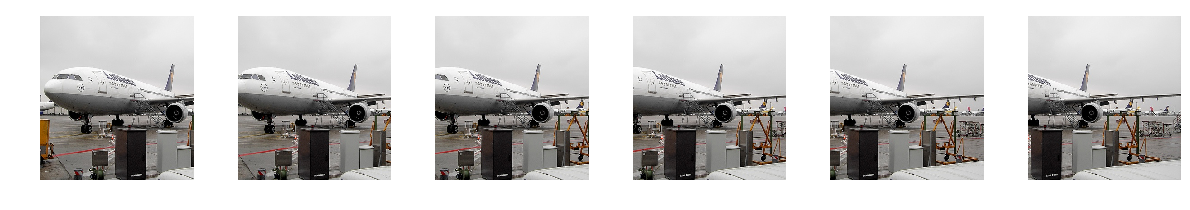

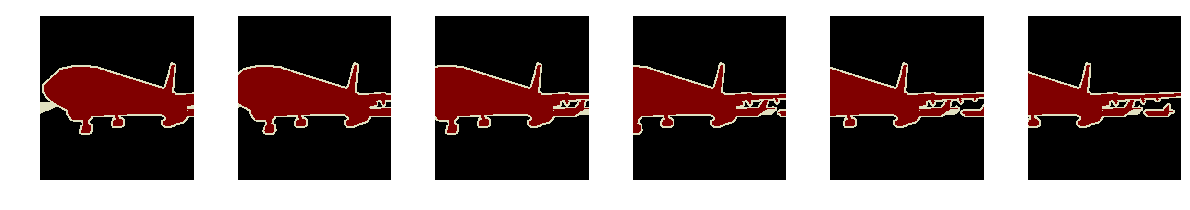

In [3]:
idx = valset[0]
im, label = PV.load_image(idx), PV.load_label(idx)

im_t, label_t = PV.make_translated_frames(im, label, shift=32, num_frames=6)

plt.figure()
for i, im in enumerate(im_t):
    plt.subplot(1, len(im_t), i + 1)
    plt.imshow(im)
    plt.axis('off')
    plt.tight_layout()
plt.figure()
for i, label in enumerate(label_t):
    plt.subplot(1, len(label_t), i + 1)
    plt.imshow(PV.palette(label))
    plt.axis('off')
    plt.tight_layout()

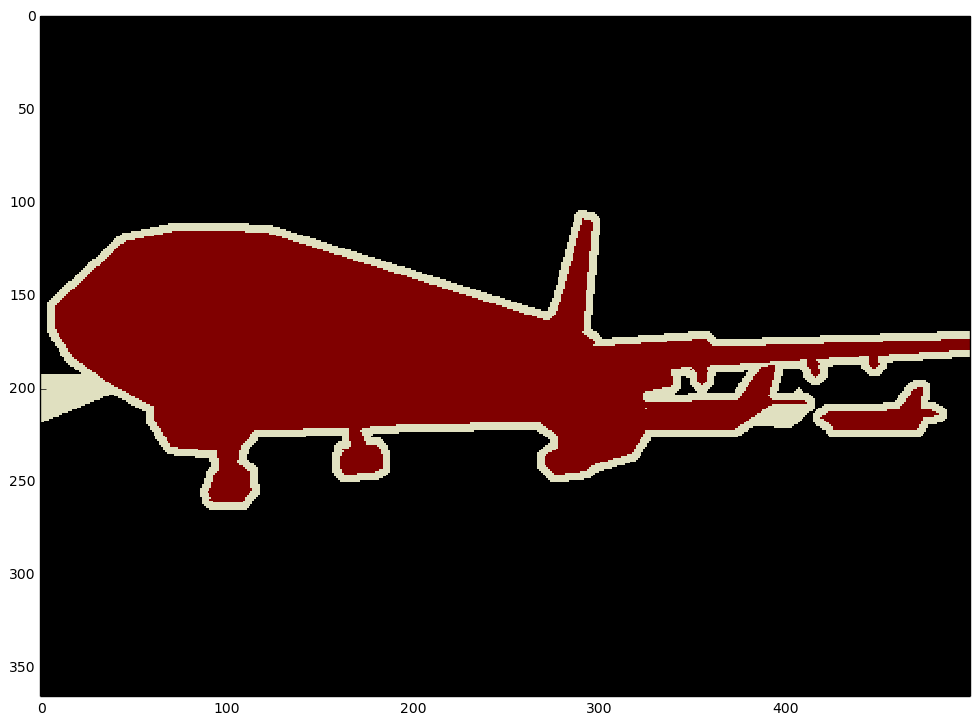

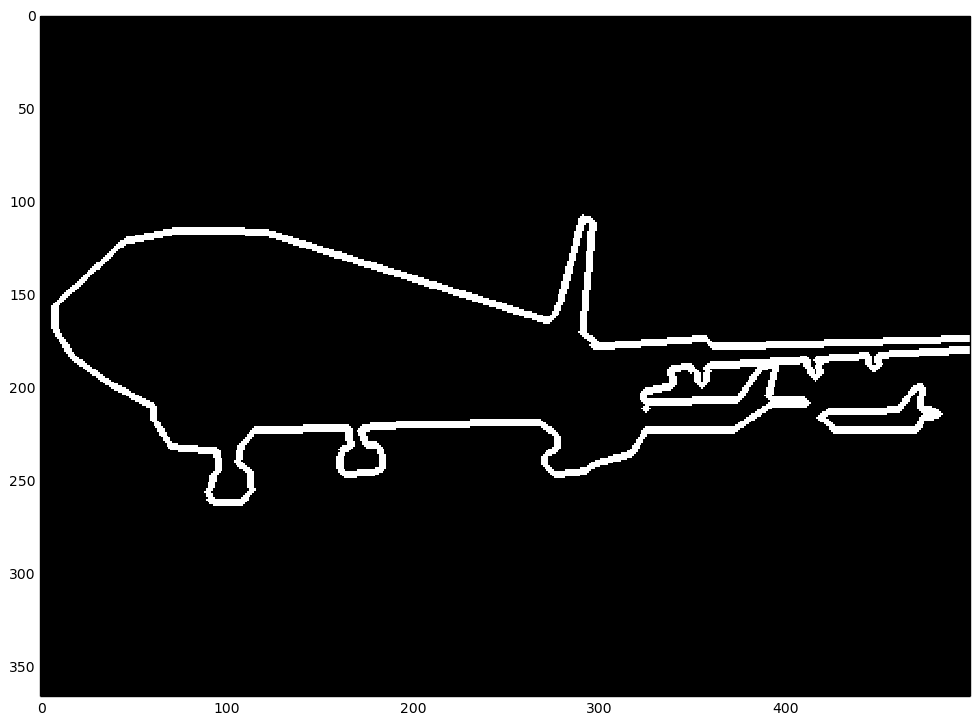

In [4]:
idx = valset[0]
label = PV.load_label(idx)
bdry = PV.make_boundaries(label, thickness=2)

plt.figure()
plt.imshow(PV.palette(label))
plt.figure()
plt.imshow(bdry)

## Evaluation

In [ ]:
n_cl = len(PV.classes)
num_frames = 6
thickness = 5
shifts = (16, 32)

# catalogue methods: the full FCN, truncated FCNs for pool3 and pool4, and the 2 and 3 stage pipelines
# instantiate the nets that will be needed
Method = namedtuple('Method', 'method arch weights infer_func, input_offset')
fcn = Method('fcn', '../nets/voc-fcn8s.prototxt', '../output/model/fcn8s-heavy-pascal.caffemodel', run_net.segrun, 2)
baseline_3stage = Method('baseline_3stage', '../nets/voc-fcn-pool3.prototxt', '../output/model/voc-fcn-pool3.caffemodel', run_net.segrun, 2)
baseline_2stage = Method('baseline_2stage', '../nets/voc-fcn-pool4.prototxt', '../output/model/voc-fcn-pool4.caffemodel', run_net.segrun, 2)
pipeline_3stage = Method('pipeline_3stage', '../nets/stage-voc-fcn8s.prototxt', '../output/model/fcn8s-heavy-pascal.caffemodel', run_net.pipeline_3stage_forward, 0)
pipeline_2stage = Method('pipeline_2stage', '../nets/stage-voc-fcn8s.prototxt', '../output/model/fcn8s-heavy-pascal.caffemodel', run_net.pipeline_2stage_forward, 1)

In [ ]:
def score_translations(method, shift, arch, weights, infer, offset):
    """
    Score the translated "video" of PASCAL VOC seg11valid images
    taking care of the net architecture and weights, the particular inference method,
    and the input offset needed to align every frame and pipeline methods.
    """
    net = caffe.Net(arch, weights, caffe.TEST)
    hist, hist_b = np.zeros((n_cl, n_cl)), np.zeros((n_cl, n_cl))
    for idx in valset:
        sys.stdout.flush()
        im, label = PV.load_image(idx), PV.load_label(idx)
        im_frames, label_frames = PV.make_translated_frames(im, label, shift=shift, num_frames=num_frames)
        im_frames, label_frames = im_frames[offset:], label_frames[offset:]
        # prepare pipelines: feed initial inputs then skip accordingly
        if method == 'pipeline_3stage':
            run_net.pipeline_fill_3stage(net, PV.preprocess(im_frames[0]), PV.preprocess(im_frames[1]))
            im_frames, label_frames = im_frames[2:], label_frames[2:]
        elif method == 'pipeline_2stage':
            run_net.pipeline_fill_2stage(net, PV.preprocess(im_frames[0]))
            im_frames, label_frames = im_frames[1:], label_frames[1:]
        for im_t, label_t in zip(im_frames, label_frames):
            out = infer(net, PV.preprocess(im_t))
            hist += score_util.score_out_gt(out, label_t, n_cl=n_cl)
            bdry = PV.make_boundaries(label_t, thickness=thickness)
            hist_b += score_util.score_out_gt_bdry(out, label_t, bdry, n_cl=n_cl)

    for name, h in zip(('seg', 'bdry'), (hist, hist_b)):
        accP, cl_accP, mean_iuP, fw_iuP = score_util.get_scores(h)
        print '{}: {}, shift {}'.format(method, name, shift)
        print 'acc\t\t cl acc\t\t mIU\t\t fwIU'
        print '{:f}\t {:f}\t {:f}\t {:f}\t'.format(100*accP, 100*cl_accP, 100*mean_iuP, 100*fw_iuP)

for shift in shifts:
    for m in (fcn, baseline_3stage, pipeline_3stage, baseline_2stage, pipeline_2stage):
        score_translations(m.method, shift, m.arch, m.weights, m.infer_func, m.input_offset)

Configure evaluation: number of classes, length of translation "video" in frames, boundary thickness, and amounts of shift, plus the catalogue of methods.

Configure Caffe